In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation

from scipy.optimize import minimize, OptimizeResult
from collections import defaultdict
from itertools import zip_longest
from functools import partial

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from copy import deepcopy

## <span style="color:blue">Implementation (Students do)</span>
<hr/>

### Methods
You will implement five optimization algorithms (descriptions available [here](https://web.archive.org/web/20230121055130/https://ruder.io/optimizing-gradient-descent/index.html)).
- Gradient descent (`gd`)
- MirrorDescent (`mirrD`)
- Accelerated gradient method (`acc`)
- Adaptive gradient method (`adagrad`)
- Adaptive moment estimation (`adam`)

The last is a very common optimizer used in practical applications -- possibly the most common in the world.

In addition, you will also implement a method for mirrorstep for the entropy regularizer and the ell_2 regularizer `mirrorstep_entropy/ell_2`. The latter of which you will use for the mirror descent algorithm and may also use for the accelerated method implementation.
Make note of the function headers: `def gd(func, x, lr, num_iters, grad):`.
- `func`: [type: function] The loss function. Takes in a point of type np.ndarray (n,) for some n and returns a float representing the value of the function at that point.
- `x`: [type: np.ndarray (n,)] The starting point of the optimization.
- `lr`: [type: real] Learning rate.
- `num_iters`: [type: int] The number of iterations of the optimization method to run.
- `grad`: [type: function] The gradient of the loss function. Takes in a point of type np.ndarray (n,) and returns an np.ndarray (n,) representing the gradient of the function at that point.

Each function will need to return a `np.ndarray` containing all the iterates over the course of the optimization.


In [2]:
#takes as input an x which is on the n-dimensional unit simplex, lr is a FIXED SCALAR Learning Rate (not a schedule function like the rest of the problem) and grad is a vector which returns gradient of a given function at point x. Return the next iterate of the mirror step.
def mirrorstep_entropy(x, lr, grad):
    return np.multiply(x, np.exp(-grad * lr))
#same as above except x lies in R^n inside of the unit simplex.
def mirrorstep_ell_2(x, lr, grad):
    return x - lr * grad

In [3]:
def gd(func, x, lr, num_iters, grad): # lr = 0.02
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        update = - lr * grad(x)
        x += update
        iterates.append(deepcopy(x))
    return np.array(iterates)

In [4]:
def mirrorD(func, x, lr, num_iters, grad): # lr = 0.2
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        gk = grad(x)
        update = mirrorstep_ell_2(x, lr, gk)
        x = update
        iterates.append(deepcopy(x))
    return np.array(iterates)


In [5]:
#we will not use a learning rate but rather use a parameter L which denotes the Lipshitz constant of the function to be optimized. Use the stepsize/learning rates you got from the PDF part of the problem. Return the y sequence of iterates
def acc(func, x, L, num_iters, grad): #lr = 1.9
    iterates = []
    y = x
    z = x
    tau = 0
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        tau = 2 / (itr + 2)
        x = tau * z + (1 - tau) * y
        y = x - (1/L) * grad(x)
        eta = 1 / (tau * L)
        z = mirrorstep_ell_2(z, eta, grad(x))
        iterates.append(deepcopy(y))
    return np.array(iterates)

In [6]:
def adagrad(func, x, lr, num_iters, grad, eps=1e-5): # lr = 0.02 
    iterates = []
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        gt = grad(x)
        #print(gt)
        G = gt * gt #np.diag(gt * gt) gt is scalar here #fix for logistic below
        #print(np.sqrt(G + eps))
        update = (lr * np.reciprocal(np.sqrt(G + eps))) * gt
        x = x - update
        
        iterates.append(deepcopy(x))
    
    return np.array(iterates)

In [7]:
def adam(func, x, lr, num_iters, grad, beta1=0.9, beta2=0.999, eps=1e-5): #lr = 0.02
    iterates = []
    mt = 0
    vt = 0
    beta1exp = beta1
    beta2exp = beta2
    iterates.append(deepcopy(x))
    for itr in range(num_iters):
        gt = grad(x)
        mt = beta1 * mt + (1 - beta1) * gt
        vt = beta2 * vt + (1 - beta2) * gt * gt
        mt_hat = mt / (1 - beta1exp)
        vt_hat = vt / (1 - beta2exp)
        beta1exp *= beta1
        beta2exp *= beta2
        
        update = - lr * np.multiply(np.reciprocal(np.sqrt(vt_hat) + eps), mt_hat)
        x += update
        iterates.append(deepcopy(x))
    return np.array(iterates)


## Testing your code
We are not providing much structure here, but now is a good time to make sure your optimization methods are working well. The cell below tests your gradient descent method on the function $f(x)=x^2$.

In [8]:
x_squared_fval = lambda x: x**2
x_squared_grad = lambda x: 2*x
iterates = acc(x_squared_fval, 2, 1.9, 100, x_squared_grad)
res=[(i,x,x_squared_fval(x)) for (i,x) in enumerate(iterates)]
#print([x[2] for x in res])

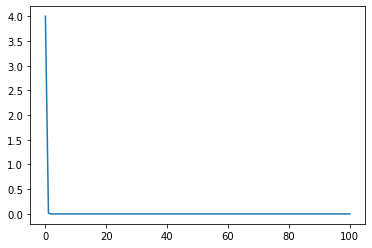

In [9]:
plt.plot([x[2] for x in res])

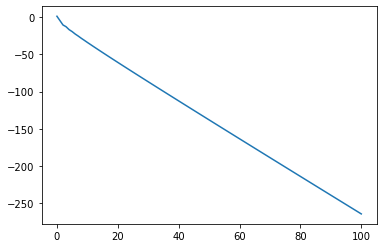

In [10]:
plt.plot([np.log(x[2]) for x in res])

In [11]:
res[1]

(1, -0.10526315789473673, 0.011080332409972275)

## <span style="color:red">Submission: Challenge</span>
<span style="color:red">In this part, you will implement the lambda functions for the functional value and the gradient function for logistic regression function given a data matrix X and output vector y. Finally you will run the above algorithms that you implemented for a classification dataset. </span>

In [12]:
np

<module 'numpy' from '/Users/rohan/opt/anaconda3/lib/python3.9/site-packages/numpy/__init__.py'>

In [13]:
#1/n \sum_i y_i log(1/(1+e^(-x_i^t w)) + (1-y_i) log(1-1/(1+e^(-x_i^t w))
def logistic_regression_fval(X,y,w):
    denom = np.exp(-np.matmul(X, w)) + 1
    logparam1 = np.reciprocal(denom)
    log1 = np.log(logparam1)
    log2 = np.log(1-logparam1)
    ret = y * log1 + (- y + 1) * log2
    return ret

def logistic_regression_grad(X,y,w):
    E = np.exp(-np.matmul(X,w))
    d = np.reciprocal(E + 1) - y
    return np.matmul(X.T,d)

In [14]:
# Standard GD

In [15]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = gd(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:12: RuntimeWarning: invalid value encountered in reciprocal
  d = np.reciprocal(E + 1) - y
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:11: RuntimeWarning: overflow encountered in exp
  E = np.exp(-np.matmul(X,w))
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:4: RuntimeWarning: invalid value encountered in reciprocal
  logparam1 = np.reciprocal(denom)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:3: RuntimeWarning: overflow encountered in exp
  denom = np.exp(-np.matmul(X, w)) + 1
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:5: RuntimeWarning: divide by zero encountered in log
  log1 = np.log(logparam1)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:6: RuntimeWarning: divide by zero encountered in log
  log2 = np.log(1-logparam1)
/var/folders/z6/5jmzv3bs66q

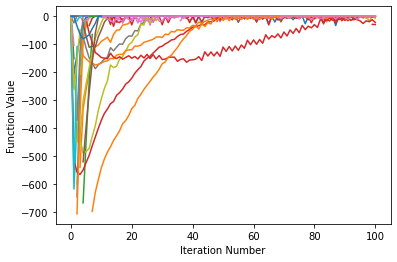

In [16]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

In [17]:
# Mirror Descent

In [18]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = mirrorD(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:12: RuntimeWarning: invalid value encountered in reciprocal
  d = np.reciprocal(E + 1) - y
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:11: RuntimeWarning: overflow encountered in exp
  E = np.exp(-np.matmul(X,w))
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:4: RuntimeWarning: invalid value encountered in reciprocal
  logparam1 = np.reciprocal(denom)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:3: RuntimeWarning: overflow encountered in exp
  denom = np.exp(-np.matmul(X, w)) + 1
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:5: RuntimeWarning: divide by zero encountered in log
  log1 = np.log(logparam1)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:6: RuntimeWarning: divide by zero encountered in log
  log2 = np.log(1-logparam1)
/var/folders/z6/5jmzv3bs66q

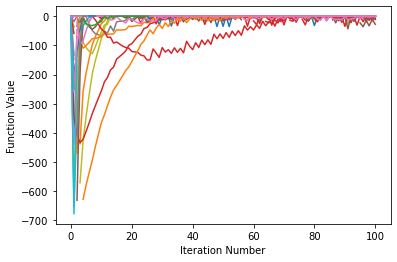

In [19]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

Run the above code for all the different algorithms and report the convergence behavior of all the algorithms. Add the plots of the function value decrease over all iterates to a PDF file (or add different cells for the run of each algorithm and the plotting and you can just use the PDF of the jupyter notebook. )

In [20]:
# Accelerated GD

In [21]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = acc(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),1,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:12: RuntimeWarning: invalid value encountered in reciprocal
  d = np.reciprocal(E + 1) - y
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:11: RuntimeWarning: overflow encountered in exp
  E = np.exp(-np.matmul(X,w))
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:4: RuntimeWarning: invalid value encountered in reciprocal
  logparam1 = np.reciprocal(denom)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:6: RuntimeWarning: divide by zero encountered in log
  log2 = np.log(1-logparam1)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:3: RuntimeWarning: overflow encountered in exp
  denom = np.exp(-np.matmul(X, w)) + 1
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:5: RuntimeWarning: divide by zero encountered in log
  log1 = np.log(logparam1)
/var/folders/z6/5jmzv3bs66q

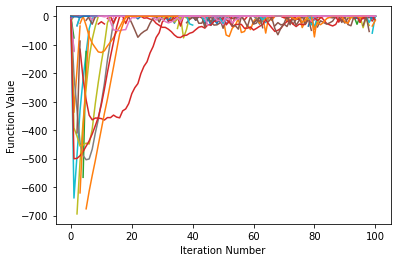

In [22]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

In [23]:
# Adagrad

In [24]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = adagrad(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),0.01,100,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:12: RuntimeWarning: invalid value encountered in reciprocal
  d = np.reciprocal(E + 1) - y
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/4006198381.py:9: RuntimeWarning: invalid value encountered in reciprocal
  update = (lr * np.reciprocal(np.sqrt(G + eps))) * gt
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:4: RuntimeWarning: invalid value encountered in reciprocal
  logparam1 = np.reciprocal(denom)


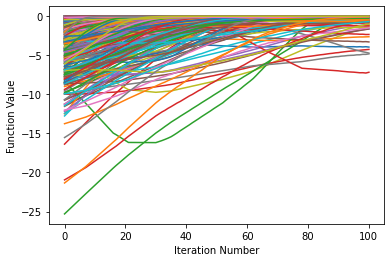

In [25]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()

In [26]:
# Adam

In [27]:
#Logistic Regression Dataset
data=datasets.load_breast_cancer()
X=data.data
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)
y=data.target
iterates = adam(lambda w:logistic_regression_fval(X,y,w),np.random.randn(X.shape[1]),20,200,lambda w:logistic_regression_grad(X,y,w))
res_bc=[(i,w,logistic_regression_fval(X,y,w)) for (i,w) in enumerate(iterates)]
#print([x for x in res_bc])

/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:12: RuntimeWarning: invalid value encountered in reciprocal
  d = np.reciprocal(E + 1) - y
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/3394900157.py:17: RuntimeWarning: invalid value encountered in reciprocal
  update = - lr * np.multiply(np.reciprocal(np.sqrt(vt_hat) + eps), mt_hat)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:11: RuntimeWarning: overflow encountered in exp
  E = np.exp(-np.matmul(X,w))
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:4: RuntimeWarning: invalid value encountered in reciprocal
  logparam1 = np.reciprocal(denom)
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:3: RuntimeWarning: overflow encountered in exp
  denom = np.exp(-np.matmul(X, w)) + 1
/var/folders/z6/5jmzv3bs66q_f0zgxn9lkxtm0000gn/T/ipykernel_77587/87376288.py:5: RuntimeWarning: divide by zero encountered in lo

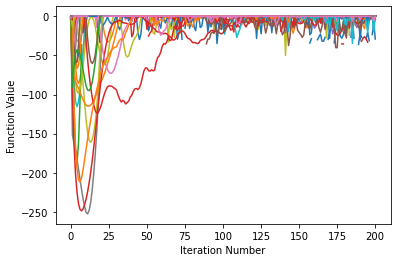

In [28]:
#Plot function value decrease over all iterations
plt.plot([x[0] for x in res_bc],[x[2] for x in res_bc])
plt.xlabel('Iteration Number')
plt.ylabel('Function Value')
plt.show()